There are many reasons why you should create your own stock database. You have your data always accessible and your able to conduct backtests ([e.g. with the bt package](http://pmorissette.github.io/bt/), maybe i will write about it someday, it's really cool!), to name two of them. The arctic package which is developed by Man AHL provides everything we need for our purposes. Arctic is a high performance datastore for numeric data. It supports Pandas, numpy arrays and pickled objects out-of-the-box, with pluggable support for other data types and optional versioning. It can query millions of rows per second per client, achieves ~10x compression on network bandwidth, ~10x compression on disk, and scales to hundreds of millions of rows per second per MongoDB instance. As a Pythonist, what more do  you need? Visit the [arctic page](https://github.com/manahl/arctic) for more details or the installation instructions. Now, I want to create a database with trade data of some of the most popular cryptocurrencies traded at the [kraken exchange](https://www.kraken.com). So, first we import the necessery packages, connect to the kraken API and initialize the mongodb.

In [1]:
import urllib
import json
import time
import pandas as pd
import datetime
from arctic import Arctic
import arctic
import subprocess
import platform
import os
import krakenex
if platform.system() == "Darwin":
    os.chdir('/users/'+os.getlogin()+'/MEGA/App')
if platform.system() == "Darwin":
	subprocess.Popen(['/usr/local/bin/mongod', '--dbpath', '/users/'+os.getlogin()+'/MEGA/App/cryptodb', '--logpath', '/users/'+os.getlogin()+'/MEGA/App/cryptodb/krakendb.log', '--fork']) 
k = krakenex.API()
k.load_key('kraken.key')

# Connect to Local MONGODB
krakendb = Arctic('localhost')

# Create the library - defaults to VersionStore
krakendb.initialize_library('Kraken')
# Access the library
kraken = krakendb['Kraken']


Couldn't import cython lz4
Library created, but couldn't enable sharding: no such command: 'enablesharding', bad cmd: '{ enablesharding: "arctic" }'. This is OK if you're not 'admin'


The [kraken API](https://github.com/veox/python3-krakenex) can be installed via pip: `pip install krakenex`. It contains public commands like gettting OHLC data, the order book or recent trades. There is also the possibility to execute private commands like adding standard orders. For that you need to create a key file with your API key and your secret. Visit the [Kraken API page](https://www.kraken.com/help/api) for more details.

Next we define the functions to import the data, get information about the data,which is already in the database or to get current account balance. Note here that I found it was about 2 times faster to access public data via [https://api.kraken.com/0/public](https://api.kraken.com/0/public) than via the krakenex API, thats why I didn't use it here. Another remark: The Kraken API has a built-in call rate limit in place to protect against DoS attacks and order book manipulation. So, it's only possible to make a call every 2 or 3 seconds, Therefore, there is this `time.sleep(3)` to pause the function, which imports the trade data for 3 seconds. Actually, this is a pity because it slows the function down by huge amount of time.

In [2]:
def updateTickData(pairs, db):
    s = '\n Begin import of '+', '.join(pairs[0:len(pairs)-1])+' and '+pairs[-1]+'\n This could take some time! \n'	
    print(s)	
    tickdata_collection = {}	
    for pair in pairs:
        print(pair+': ')
        tickdata_collection[pair]=get_all_kraken_trades(pair, db = kraken)
    s = '\nAll Pairs are up do date now!\n'	
    print(s)		
    return tickdata_collection

        
def getInfo(db):
    infolist = kraken.list_versions()
    s = '\n Last updates: \n'
    print(s)
    for list in infolist:
        s = list['symbol']+' updated at ' + list['date'].strftime('%Y-%m-%d %H:%M:%S')+ ', Version: '+ str(list['version'])+'\n'
        print(s)
    snapshots =  kraken.list_snapshots()
    s = '\n Last snapshots: \n'
    print(s)
    for list in snapshots:
        s = list+'\n'
        print(s)    

def get_all_kraken_trades(pair, since = None, db = None):
    """
    Input: 
        pair = pair name
        since = unix datestamp, default is None (imports every trade from the beginning, this could take a long time)
    Output:
        Pandas DataFrame
    """
    history = pd.DataFrame( columns = ['price', 'volume', 'time', 'buy/sell', 'market/limit'])
    if pair in db.list_symbols():
        since = db.read(pair).metadata['last']     
    elif since == None:
        since = 0 
    try:
        while True:    
            data = urllib.request.urlopen("https://api.kraken.com/0/public/Trades?pair="+pair+"&since="+str(since)).read()
            data = data.decode()
            data = json.loads(data)
            last = int(data['result']['last'])
            data = data['result'][pair]
            data = pd.DataFrame(data)
            if data.empty:
                break
            dates = [datetime.datetime.fromtimestamp(ts) for ts in (data[2].values)]
            data.index = pd.DatetimeIndex(dates)
            data = data.iloc[:,0:5]
            data.iloc[:,0:3] = data.iloc[:,0:3].astype(float)
            data.columns = ['price', 'volume', 'time', 'buy/sell', 'market/limit']
            history = history.append(data) #ignore_index=True) 
            since = last
            print('imported data until: '+history.index[-1].strftime('%Y-%m-%d %H:%M:%S'))
            time.sleep(3)
    except Exception as e:
            print(str(e))
    db.append(pair, history, metadata={'last': last, 'source': 'Kraken'})
    time.sleep(2)
    alltrades = db.read(pair).data
    return alltrades

def get_kraken_balance(db = None):
    balance = k.query_private('Balance')['result']
    df = pd.DataFrame(list(balance.items()))
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop(0))
    df = df.astype(float)
    last = datetime.datetime.now()
    df.index = pd.DatetimeIndex([last])
    if db:
        db.append('Balance', df, metadata={'last': last, 'source': 'Kraken'})
        allbalance = db.read('Balance').data
        return df, allbalance
    else:
        return df
    
def add_kraken_order(pair, buysell, ordertype, volume, **kwargs  ):
    '''
    Input:
        pair = asset pair
        buysell = type of order (buy/sell)
        ordertype = order type:
            market
            limit (price = limit price)
            stop-loss (price = stop loss price)
            take-profit (price = take profit price)
            stop-loss-profit (price = stop loss price, price2 = take profit price)
            stop-loss-profit-limit (price = stop loss price, price2 = take profit price)
            stop-loss-limit (price = stop loss trigger price, price2 = triggered limit price)
            take-profit-limit (price = take profit trigger price, price2 = triggered limit price)
            trailing-stop (price = trailing stop offset)
            trailing-stop-limit (price = trailing stop offset, price2 = triggered limit offset)
            stop-loss-and-limit (price = stop loss price, price2 = limit price)
            settle-position
        price = price (optional.  dependent upon ordertype)
        price2 = secondary price (optional.  dependent upon ordertype)
        volume = order volume in lots
        leverage = amount of leverage desired (optional.  default = none)
        oflags = comma delimited list of order flags (optional):
            viqc = volume in quote currency (not available for leveraged orders)
            fcib = prefer fee in base currency
            fciq = prefer fee in quote currency
            nompp = no market price protection
            post = post only order (available when ordertype = limit)
        starttm = scheduled start time (optional):
            0 = now (default)
            +<n> = schedule start time <n> seconds from now
            <n> = unix timestamp of start time
        expiretm = expiration time (optional):
            0 = no expiration (default)
            +<n> = expire <n> seconds from now
            <n> = unix timestamp of expiration time
        userref = user reference id.  32-bit signed number.  (optional)
        validate = validate inputs only.  do not submit order (optional)

        optional closing order to add to system when order gets filled:
            close[ordertype] = order type
            close[price] = price
            close[price2] = secondary price
            
            
    Output:
        descr = order description info
            order = order description
            close = conditional close order description (if conditional close set)
        txid = array of transaction ids for order (if order was added successfully)
    '''       
    orderinfo = k.query_private('AddOrder', {'pair': pair,'type' : buysell, 
                                 'ordertype' : ordertype, 'volume' : volume,
                                  **kwargs   })
    if bool(orderinfo['error']):
        raise Exception(orderinfo['error'])
    return orderinfo['result']['txid'], orderinfo['result']['descr']

Let's now run the functions to see what happens:

In [3]:
get_kraken_balance()

,XETH,XETC,XZEC,XXRP,XXBT,ZEUR,XDAO
2017-06-04 16:37:44.934286,2.75,7.200000e-09,0.0,216.0,0.0,49.4045,0.0


The function `get_kraken_balance()` returns a pandas Dataframe with the current balance. If you give the function your arctic database as input, the balance will be saved in the database and it also returns a Dataframe with all your past balance(if you've saved it in your database)

In [4]:
getInfo(kraken)


 Last updates: 

Balance updated at 2017-06-03 13:44:27, Version: 574

Balance updated at 2017-06-03 12:44:19, Version: 573

Balance updated at 2017-06-03 11:44:10, Version: 572

Balance updated at 2017-06-01 04:32:59, Version: 517

XETHZEUR updated at 2017-06-04 14:07:30, Version: 558

XETHZEUR updated at 2017-06-04 13:36:04, Version: 557

XETHZEUR updated at 2017-06-03 23:37:48, Version: 556

XETHZEUR updated at 2017-06-02 03:39:09, Version: 512

XETHZEUR updated at 2017-05-02 17:34:01, Version: 1

XXBTZEUR updated at 2017-06-04 14:07:41, Version: 23

XXBTZEUR updated at 2017-06-04 13:37:09, Version: 22

XXBTZEUR updated at 2017-06-03 23:37:59, Version: 21

XXBTZEUR updated at 2017-06-03 18:33:55, Version: 15

XXBTZEUR updated at 2017-05-02 17:32:29, Version: 2

XXRPZEUR updated at 2017-06-04 14:08:02, Version: 7

XXRPZEUR updated at 2017-06-04 13:37:37, Version: 6

XXRPZEUR updated at 2017-06-03 23:38:11, Version: 5

XXRPZEUR updated at 2017-06-03 19:33:59, Version: 1

XZECZEUR upd

`getInfo(db)` prints among three others the last version of all items in the database with the exact date. It's also possible to snapshot your databse. This function will also print the snapshots you've created so far. 

Now the main function in this post is `updateTickData(pairs, db)`. Basically, for each pair in the list "pairs", it looks into the databse for the last imported values and fetches the values henceforward. Otherwise it begins from the beginning if no starting value is passed. Besides the previously mentioned reason why it takes so long time to import all the trades, there is another one which is quite time consuming. That is for every loop iteration you can only import up to 1000 trades. I think to have all the trades in our database we have to go through it, but if you have a quicker solution, I would be a happy recipient. 

In [5]:
pairs = ['XETHZEUR','XXBTZEUR', 'XZECZEUR', 'XXRPZEUR']

trades = updateTickData(pairs, kraken)


 Begin import of XETHZEUR, XXBTZEUR, XZECZEUR and XXRPZEUR
 This could take some time! 

XETHZEUR: 
imported data until: 2017-06-04 15:05:14
imported data until: 2017-06-04 15:29:43
imported data until: 2017-06-04 15:46:33
imported data until: 2017-06-04 16:13:08
imported data until: 2017-06-04 16:38:27
imported data until: 2017-06-04 16:38:33
XXBTZEUR: 
imported data until: 2017-06-04 15:09:16
imported data until: 2017-06-04 15:52:23
imported data until: 2017-06-04 16:25:13
imported data until: 2017-06-04 16:38:56
XZECZEUR: 
imported data until: 2017-06-04 16:39:07
XXRPZEUR: 
imported data until: 2017-06-04 16:38:57

All Pairs are up do date now!



As I have already most of the data in the database, it was quite quick to update it. `updateTickData(pairs, db)` returns a collection of pandas Dataframes containing all trades of the desired pairs. Let's have a look at the first few trades of the pair ETH/EUR. For every trade we have the price, volume, a unix timestamp, whether it was buy or sell and whether it was at the market or a limit order. 

In [6]:
trades['XETHZEUR'].head()

,price,volume,time,buy/sell,market/limit
index,,,,,
2015-08-07 13:09:50.909800,20.000,4.500000,1.438946e+09,b,l
2015-08-07 13:09:51.236500,20.000,0.480000,1.438946e+09,b,l
2015-08-07 13:12:34.121200,20.000,3.372151,1.438946e+09,s,l
2015-08-07 13:25:12.641400,2.501,11.375440,1.438947e+09,s,l
2015-08-07 13:29:12.133200,2.501,0.000560,1.438947e+09,b,l


What possibilities do we have, now that we can quickly load all the trades into the python workspace? For example we can do nice plots or with the Kraken API we can automate our trading strategies. The two following cells illustrate simple, such examples.

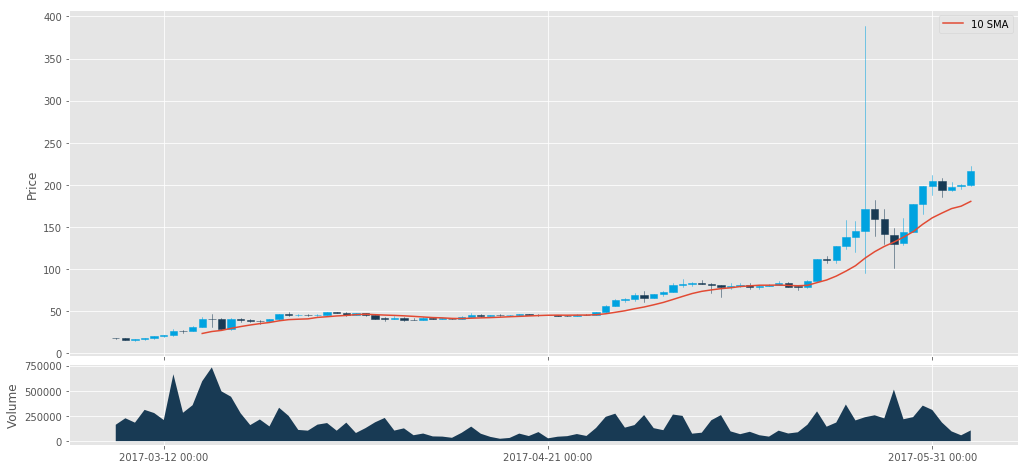

In [7]:
%matplotlib inline
import matplotlib.dates as mdates
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib
import matplotlib.pyplot as plt

stop = datetime.datetime.now()
start = stop-datetime.timedelta(days=90)
mask = (trades['XETHZEUR'].index > start) & (trades['XETHZEUR'].index <= datetime.datetime.now())
data = trades['XETHZEUR'].loc[mask]

ohlc = data.price.resample('1D').ohlc().dropna().iloc[1:,:]
volume = data.volume.resample('1D').sum().dropna().iloc[1:]
dateStamp = np.array(ohlc.index).astype('datetime64[s]')
dateStamp = dateStamp.tolist()
df = pd.DataFrame({'Datetime':dateStamp})
df['MPLDate'] = df['Datetime'].apply(lambda date: mdates.date2num(date.to_pydatetime()))
df.index=dateStamp
ohlc.insert(0,'MPLDate', df.MPLDate)

fig=plt.figure(figsize=(17, 8))
# Main Graph
a = plt.subplot2grid((10,8), (0,0), rowspan = 8, colspan = 8)
# Volume
a2 = plt.subplot2grid((10,8), (8,0), sharex = a, rowspan = 2, colspan = 8)

matplotlib.style.use("ggplot")
darkColor = "#183A54"
lightColor = "#00A3E0"
candlestick_ohlc(a, ohlc[['MPLDate', 'open', 'high', 'low', 'close']].astype(float).values, width=0.768, colorup=lightColor, colordown=darkColor)
a.set_ylabel("Price") 
a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(3))
a.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))               
a2.set_ylabel("Volume") 
a2.fill_between(ohlc.MPLDate,0, volume.astype(float), facecolor='#183A54')
plt.setp(a.get_xticklabels(), visible=False)

sma=ohlc['close'].rolling(window=10).mean()
label = str(10)+" SMA"
a.plot(ohlc['MPLDate'],sma, label=label)
a.legend(loc=0)

A nice thing is that we can customize our candlestick charts. We can choose the time frame(here the last 90 days) and with the pandas resample function we can create the desired ohlc data(here one day data). The `mpl_finance` module allows now to plot nice candlestick charts. It's also possible to plot some financial indicators like e.g. here a simple moving average. The same way as above we could add a MACD indicator for example. There is a library called [TA-Lib](http://ta-lib.org) which contains more than 200 indicators. It's worth to have a look at. Let's now look at one possibility to implement an automated trading strategy:

In [8]:
pairs = ['XXBTZEUR']
import math
import threading
def automatedTradingStrategy():
        fastMA = {}
        slowMA = {}
        mask = {}
        tickdata_collection = {}
        for pair in pairs:
                actbalance, allbalance = get_kraken_balance(db = kraken)
                tickdata_collection[pair]=get_all_kraken_trades(pair, db = kraken)
                tickdata_collection[pair]=tickdata_collection[pair].price.resample('1H').ohlc().dropna().iloc[-241:-1,:]
                fastMA[pair] = tickdata_collection[pair].close.ewm(span=120).mean()
                slowMA[pair] = tickdata_collection[pair].close.ewm(span=240).mean()
                mask[pair] = fastMA[pair][-1]>slowMA[pair]
                if bool((actbalance.ZEUR.values >= 100) & (mask[pair][-1] == True)):
                    txid, descr = add_kraken_order(pair, 'buy', 'market', math.floor(float(actbalance.ZEUR))/tickdata_collection[pair].close[-1])  
                    print('New Order: ' +str(txid)+ '\nInfo: ')
                    print(descr)
                elif bool((actbalance[pair[0:4]].values > 0) & (mask[pair][-1] == False)):
                    txid, descr = gkd.add_kraken_order(pair, 'sell', 'market', int(actbalance[pair[0:4]].values) )
                    print('New Order: ' +str(txid)+ '\nInfo: ')
                    print(descr)
                else:
                    print('Nothing new this hour!')
        global t            
        t = threading.Timer(3600, automatedTradingStrategy)
        t.start()

In [9]:
automatedTradingStrategy()

/Users/anaconda/lib/python3.5/site-packages/arctic/store/_ndarray_store.py:237: FutureWarning: Assignment between structured arrays with different field names will change in numpy 1.13.

Previously fields in the dst would be set to the value of the identically-named field in the src. In numpy 1.13 fields will instead be assigned 'by position': The Nth field of the dst will be set to the Nth field of the src array.

See the release notes for details
  old_arr = self._do_read(collection, previous_version, symbol).astype(dtype)


imported data until: 2017-06-04 16:40:42
imported data until: 2017-06-04 16:40:48
imported data until: 2017-06-04 16:40:55
Nothing new this hour!


This is a simple strategy just for the pair XBT/EUR but very complex strategies for more than one pair are also possible to code. This strategie states "buy/hold"  if the exponential moving average of 120 hours (5 days) is above the exponential moving average of 240 hours (10 days) and "sell" if it's below. With the threading module we can execute the function every hour, so that it first updates the latest trade data and computes the relevant conditions afterwards. Then when the conditions are met it buys or sells at the market or it holds the current positions. To stop the function just call `t.cancel()`. I'm sure there are plenty possibilities to implement automated trading, that's just one of them and I'm not sure if it is a good one. 

Be aware that the above strategy is very, very simple and will not guarantee any gains! 

In [10]:
t.cancel()